## makemore: becoming a backprop ninja

In [1]:
# there no change change in the first several cells from last lecture

In [2]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In [3]:
# download the names.txt file from github
!wget https://raw.githubusercontent.com/karpathy/makemore/master/names.txt

'wget' is not recognized as an internal or external command,
operable program or batch file.


In [4]:
# read in all the words
words = open('names.txt', 'r').read().splitlines()
print(len(words))
print(max(len(w) for w in words))
print(words[:8])

32033
15
['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']


In [5]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [6]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):
  X, Y = [], []

  for w in words:
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr,  Ytr  = build_dataset(words[:n1])     # 80%
Xdev, Ydev = build_dataset(words[n1:n2])   # 10%
Xte,  Yte  = build_dataset(words[n2:])     # 10%

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [7]:
# ok biolerplate done, now we get to the action:

In [8]:
# utility function we will use later when comparing manual gradients to PyTorch gradients
def cmp(s, dt, t):
  ex = torch.all(dt == t.grad).item()
  app = torch.allclose(dt, t.grad)
  maxdiff = (dt - t.grad).abs().max().item()
  print(f'{s:15s} | exact: {str(ex):5s} | approximate: {str(app):5s} | maxdiff: {maxdiff}')

In [9]:
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 64 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)
# Layer 1
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3)/((n_embd * block_size)**0.5)
b1 = torch.randn(n_hidden,                        generator=g) * 0.1 # using b1 just for fun, it's useless because of BN
# Layer 2
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.1
b2 = torch.randn(vocab_size,                      generator=g) * 0.1
# BatchNorm parameters
bngain = torch.randn((1, n_hidden))*0.1 + 1.0
bnbias = torch.randn((1, n_hidden))*0.1

# Note: I am initializating many of these parameters in non-standard ways
# because sometimes initializating with e.g. all zeros could mask an incorrect
# implementation of the backward pass.

parameters = [C, W1, b1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

4137


In [10]:
batch_size = 32
n = batch_size # a shorter variable also, for convenience
# construct a minibatch
ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y

In [11]:
# forward pass, "chunkated" into smaller steps that are possible to backward one at a time

emb = C[Xb] # embed the characters into vectors
embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
# Linear layer 1
hprebn = embcat @ W1 + b1 # hidden layer pre-activation
# BatchNorm layer
bnmeani = 1/n*hprebn.sum(0, keepdim=True)
bndiff = hprebn - bnmeani
bndiff2 = bndiff**2
bnvar = 1/(n-1)*(bndiff2).sum(0, keepdim=True) # note: Bessel's correction (dividing by n-1, not n)
bnvar_inv = (bnvar + 1e-5)**-0.5
bnraw = bndiff * bnvar_inv
hpreact = bngain * bnraw + bnbias
# Non-linearity
h = torch.tanh(hpreact) # hidden layer
# Linear layer 2
logits = h @ W2 + b2 # output layer
# cross entropy loss (same as F.cross_entropy(logits, Yb))
logit_maxes = logits.max(1, keepdim=True).values
norm_logits = logits - logit_maxes # subtract max for numerical stability
counts = norm_logits.exp()
counts_sum = counts.sum(1, keepdims=True)
counts_sum_inv = counts_sum**-1 # if I use (1.0 / counts_sum) instead then I can't get backprop to be bit exact...
probs = counts * counts_sum_inv
logprobs = probs.log()
loss = -logprobs[range(n), Yb].mean()

# PyTorch backward pass
for p in parameters:
  p.grad = None
for t in [logprobs, probs, counts, counts_sum, counts_sum_inv, # afaik there is no cleaner way
          norm_logits, logit_maxes, logits, h, hpreact, bnraw,
         bnvar_inv, bnvar, bndiff2, bndiff, hprebn, bnmeani,
         embcat, emb]:
  t.retain_grad()
loss.backward()
loss

tensor(3.3413, grad_fn=<NegBackward0>)

In [12]:
# Exercise 1: backprop through the whole thing manually,
# backpropagating through exactly all of the variables
# as they are defined in the forward pass above, one by one

# -----------------
print("1. logprobs: ",logprobs.shape) # the dlogprobs and logprobs will be the same size, thou only the [range(n), Yb] will affect the loss, so the rest will be zero
dlogprobs = torch.zeros_like(logprobs)
dlogprobs[range(n), Yb] = -1.0 / batch_size
# -----------------
print("2. probs: ",probs.shape)
dprobs = dlogprobs * (1.0 / probs) # Chain-rule: dloss/dprobs = dloss/dlogprobs * dlogprobs/dprobs
# -----------------
'''The probabilities (probs) depend on two variables: counts and counts_sum_inv.
However, counts_sum_inv itself is derived from counts. 
Therefore, to correctly compute the gradients during backpropagation, 
we must consider the dependence of probs on both counts and counts_sum_inv, 
as well as the dependence of counts_sum_inv on counts.'''
print("3.: ",counts_sum_inv.shape, counts.shape)
dcounts_sum_inv = (dprobs * counts).sum(1, keepdim=True)

dcounts = dprobs * counts_sum_inv
# -----------------
print("4. counts_sum: ", counts_sum.shape)
dcounts_sum = dcounts_sum_inv * (-counts_sum**-2)
# -----------------
print("5. counts: ", counts.shape)
dcounts += dcounts_sum * torch.ones_like(counts) # the tensor will be zero after derivative, except at counts place
# -----------------
print("6. norm_logits: ", norm_logits.shape)
dnorm_logits = dcounts * norm_logits.exp()
# -----------------
''' Same with 'logits' as by the 'counts' '''
print("7. logit_maxes: ", logit_maxes.shape, " logits: ", logits.shape)
dlogit_maxes = (dnorm_logits * (-1)).sum(1, keepdim=True)

dlogits = dnorm_logits * (1.0)
# -----------------
print("8. logits: ", logits.shape)
''' 
dlogit_helper = torch.zeros_like(logits)
max_indices = logits.max(1, keepdim=True).indices
for i in range(max_indices.size(0)):
    dlogit_helper[i, max_indices[i, 0]] = 1
dlogits += dlogit_maxes * dlogit_helper

We could use one_hot instead of the above version. 
We have max indices, and the derivated will be 0 where not max and 1 where max
'''
# pytorch's max function returns not only the value, 
# it returns the corresponding indices as well, so that is needed for the derivation, 
# because we need to know where are values, where are not
dlogits += F.one_hot(logits.max(1).indices, num_classes=logits.shape[1]) * dlogit_maxes 
# -----------------
print("9. h: ", h.shape)
dh = dlogits @ W2.T 
# -----------------
print("11. W2: ", W2.shape)
dW2 = h.T @ dlogits 
# -----------------
print("12. b2: ", b2.shape)
db2 = (dlogits * torch.ones_like(b2)).sum(0, keepdim=True)
# -----------------
print("13. hpreact: ", hpreact.shape)
dhpreact = dh * (1 - torch.tanh(hpreact)**2)
# -----------------
print("14. bnraw: ", bnraw.shape)
dbnraw = dhpreact * bngain
# -----------------
print("15. bngain: ", bngain.shape)
dbngain = (dhpreact * bnraw).sum(0, keepdim=True)
# -----------------
print("16. bnbias: ", bnbias.shape)
dbnbias = (dhpreact * torch.ones_like(bnbias)).sum(0, keepdim=True)
# -----------------
print("17. bnvar_inv: ", bnvar_inv.shape)
dbnvar_inv = (dbnraw * bndiff).sum(0, keepdim=True)
# -----------------
print("18. bndiff: ", bndiff.shape)
dbndiff = dbnraw * bnvar_inv
# -----------------
print("19. bnvar: ", bnvar.shape)
dbnvar = dbnvar_inv * (-0.5*(bnvar + 1e-5)**-1.5).sum(0, keepdim=True)
# -----------------
print("20. bndiff2: ", bndiff2.shape)
dbndiff2 = dbnvar * (1/(n-1)) * torch.ones_like(bndiff2)
# -----------------
print("21. bndiff: ", bndiff.shape)
dbndiff += dbndiff2 * 2 * bndiff
# -----------------
print("22. bnmeani: ", bnmeani.shape)
dbnmeani = (dbndiff * -torch.ones_like(bnmeani)).sum(0, keepdim=True)
# -----------------
print("23. hprebn: ", hprebn.shape)
dhprebn = dbndiff * torch.ones_like(hprebn)
# -----------------
print("24. hprebn: ", hprebn.shape)
dhprebn += dbnmeani * (1/n) * torch.ones_like(hprebn)
# -----------------
print("25. embcat: ", embcat.shape)
# hprebn = embcat @ W1 + b1
dembcat = dhprebn @ W1.T
# -----------------
print("26. W1: ", W1.shape)
dW1 = embcat.T @ dhprebn
# -----------------
print("27. b1: ", b1.shape)
db1 = (dhprebn * torch.ones_like(b1)).sum(0, keepdim=True)
# -----------------
print("28. emb: ", emb.shape)
demb = dembcat.view(emb.shape) # Since the values were the same, no operation was implied, it is just a restructure
# -----------------
print("29. C: ", C.shape)
# Here no mathematical operation happens, '.view' and '[Xb]' indexing only reshapes and fetch data
dC = torch.zeros_like(C)
for k in range(Xb.shape[0]):    # Iterates through 'Xb' and then fetch by index by index and aggregates the grads from 'demb' to the correct place in dC
    for j in range(Xb.shape[1]):
        ix = Xb[k,j]
        dC[ix] += demb[k,j]
        
print(dC.shape)
# -----------------

print()
cmp('logprobs', dlogprobs, logprobs)
cmp('probs', dprobs, probs)
cmp('counts_sum_inv', dcounts_sum_inv, counts_sum_inv)
cmp('counts_sum', dcounts_sum, counts_sum)
cmp('counts', dcounts, counts)
cmp('norm_logits', dnorm_logits, norm_logits)
cmp('logit_maxes', dlogit_maxes, logit_maxes)
cmp('logits', dlogits, logits)
cmp('h', dh, h)
cmp('W2', dW2, W2)
cmp('b2', db2, b2)
cmp('hpreact', dhpreact, hpreact)
cmp('bngain', dbngain, bngain)
cmp('bnbias', dbnbias, bnbias)
cmp('bnraw', dbnraw, bnraw)
cmp('bnvar_inv', dbnvar_inv, bnvar_inv)
cmp('bnvar', dbnvar, bnvar)
cmp('bndiff2', dbndiff2, bndiff2)
cmp('bndiff', dbndiff, bndiff)
cmp('bnmeani', dbnmeani, bnmeani)
cmp('hprebn', dhprebn, hprebn)
cmp('embcat', dembcat, embcat)
cmp('W1', dW1, W1)
cmp('b1', db1, b1)
cmp('emb', demb, emb)
cmp('C', dC, C)

1. logprobs:  torch.Size([32, 27])
2. probs:  torch.Size([32, 27])
3.:  torch.Size([32, 1]) torch.Size([32, 27])
4. counts_sum:  torch.Size([32, 1])
5. counts:  torch.Size([32, 27])
6. norm_logits:  torch.Size([32, 27])
7. logit_maxes:  torch.Size([32, 1])  logits:  torch.Size([32, 27])
8. logits:  torch.Size([32, 27])
9. h:  torch.Size([32, 64])
11. W2:  torch.Size([64, 27])
12. b2:  torch.Size([27])
13. hpreact:  torch.Size([32, 64])
14. bnraw:  torch.Size([32, 64])
15. bngain:  torch.Size([1, 64])
16. bnbias:  torch.Size([1, 64])
17. bnvar_inv:  torch.Size([1, 64])
18. bndiff:  torch.Size([32, 64])
19. bnvar:  torch.Size([1, 64])
20. bndiff2:  torch.Size([32, 64])
21. bndiff:  torch.Size([32, 64])
22. bnmeani:  torch.Size([1, 64])
23. hprebn:  torch.Size([32, 64])
24. hprebn:  torch.Size([32, 64])
25. embcat:  torch.Size([32, 30])
26. W1:  torch.Size([30, 64])
27. b1:  torch.Size([64])
28. emb:  torch.Size([32, 3, 10])
29. C:  torch.Size([27, 10])
torch.Size([27, 10])

logprobs     

In [13]:
# Exercise 2: backprop through cross_entropy but all in one go
# to complete this challenge look at the mathematical expression of the loss,
# take the derivative, simplify the expression, and just write it out

# forward pass

# before:
# logit_maxes = logits.max(1, keepdim=True).values
# norm_logits = logits - logit_maxes # subtract max for numerical stability
# counts = norm_logits.exp()
# counts_sum = counts.sum(1, keepdims=True)
# counts_sum_inv = counts_sum**-1 # if I use (1.0 / counts_sum) instead then I can't get backprop to be bit exact...
# probs = counts * counts_sum_inv
# logprobs = probs.log()
# loss = -logprobs[range(n), Yb].mean()

# now:
loss_fast = F.cross_entropy(logits, Yb)
print(loss_fast.item(), 'diff:', (loss_fast - loss).item())

3.341292142868042 diff: 0.0


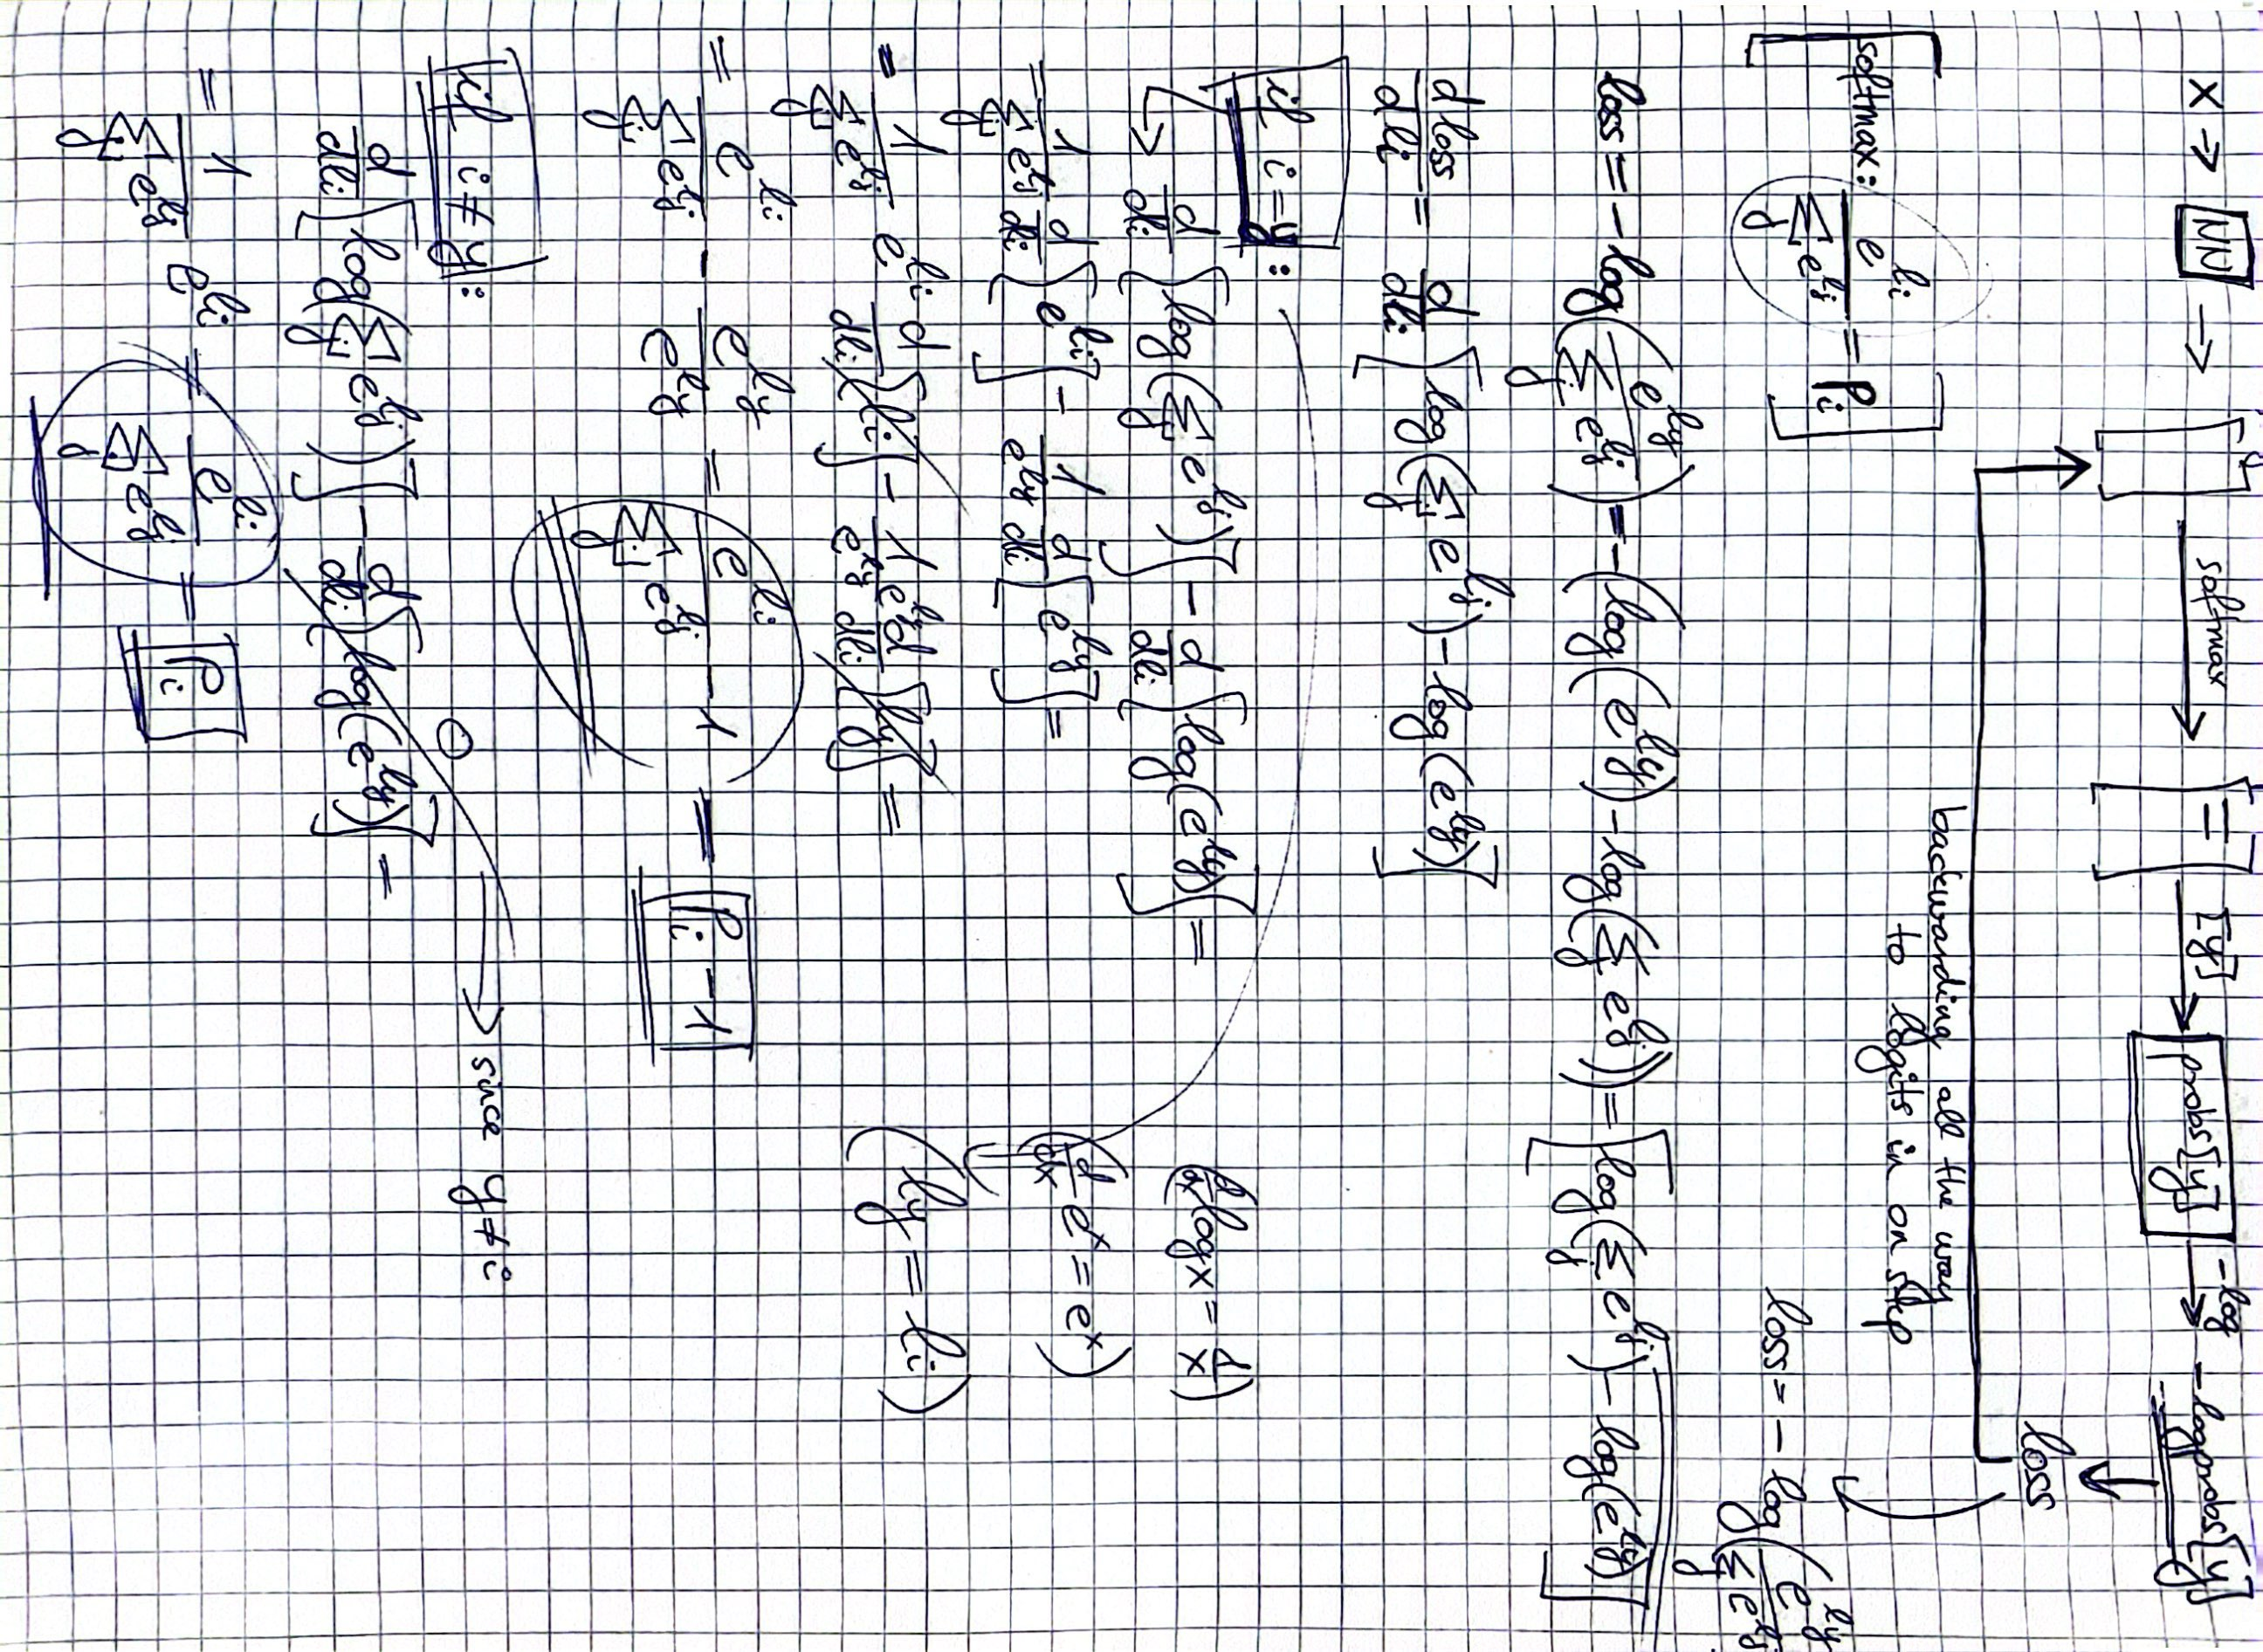

In [14]:
# backward pass
# -----------------
# YOUR CODE HERE :)
dlogits = F.softmax(logits, 1) # pass the logits through the softmax func
dlogits[range(n), Yb] -= 1 # since derivation only care about the case where i=y: we are subtract 1 from those values
dlogits /= n # We get the average of it
print(dlogits)
#-----------------

cmp('logits', dlogits, logits) # I can only get approximate to be true, my maxdiff is 6e-9

tensor([[ 0.0021,  0.0028,  0.0006,  0.0016,  0.0006,  0.0025,  0.0008,  0.0011,
         -0.0307,  0.0009,  0.0012,  0.0011,  0.0012,  0.0009,  0.0011,  0.0005,
          0.0003,  0.0006,  0.0005,  0.0018,  0.0016,  0.0007,  0.0007,  0.0022,
          0.0018,  0.0008,  0.0008],
        [ 0.0017,  0.0018,  0.0029,  0.0015,  0.0011,  0.0010,  0.0006,  0.0014,
          0.0007,  0.0007,  0.0017,  0.0015,  0.0015,  0.0009, -0.0298,  0.0012,
          0.0009,  0.0005,  0.0006,  0.0011,  0.0006,  0.0008,  0.0004,  0.0020,
          0.0007,  0.0011,  0.0009],
        [ 0.0007,  0.0007,  0.0005,  0.0004,  0.0006,  0.0012,  0.0019,  0.0019,
          0.0020,  0.0009,  0.0007,  0.0012,  0.0015,  0.0014,  0.0007, -0.0304,
          0.0004,  0.0011,  0.0008,  0.0034,  0.0020,  0.0013,  0.0012,  0.0012,
          0.0011,  0.0006,  0.0009],
        [ 0.0010,  0.0008,  0.0014,  0.0016,  0.0017,  0.0008,  0.0016,  0.0014,
          0.0015,  0.0006,  0.0012,  0.0009,  0.0011,  0.0013,  0.0019,  0.0021

In [15]:
# Exercise 3: backprop through batchnorm but all in one go
# to complete this challenge look at the mathematical expression of the output of batchnorm,
# take the derivative w.r.t. its input, simplify the expression, and just write it out
# BatchNorm paper: https://arxiv.org/abs/1502.03167

# forward pass

# before:
# bnmeani = 1/n*hprebn.sum(0, keepdim=True)
# bndiff = hprebn - bnmeani
# bndiff2 = bndiff**2
# bnvar = 1/(n-1)*(bndiff2).sum(0, keepdim=True) # note: Bessel's correction (dividing by n-1, not n)
# bnvar_inv = (bnvar + 1e-5)**-0.5
# bnraw = bndiff * bnvar_inv
# hpreact = bngain * bnraw + bnbias

# now:
hpreact_fast = bngain * (hprebn - hprebn.mean(0, keepdim=True)) / torch.sqrt(hprebn.var(0, keepdim=True, unbiased=True) + 1e-5) + bnbias
print('max diff:', (hpreact_fast - hpreact).abs().max())

max diff: tensor(4.7684e-07, grad_fn=<MaxBackward1>)


In [16]:
# backward pass

# before we had:
# dbnraw = bngain * dhpreact
# dbndiff = bnvar_inv * dbnraw
# dbnvar_inv = (bndiff * dbnraw).sum(0, keepdim=True)
# dbnvar = (-0.5*(bnvar + 1e-5)**-1.5) * dbnvar_inv
# dbndiff2 = (1.0/(n-1))*torch.ones_like(bndiff2) * dbnvar
# dbndiff += (2*bndiff) * dbndiff2
# dhprebn = dbndiff.clone()
# dbnmeani = (-dbndiff).sum(0)
# dhprebn += 1.0/n * (torch.ones_like(hprebn) * dbnmeani)

# calculate dhprebn given dhpreact (i.e. backprop through the batchnorm)
# (you'll also need to use some of the variables from the forward pass up above)

# -----------------
# YOUR CODE HERE :)
dhprebn = None # TODO. my solution is 1 (long) line
# -----------------

cmp('hprebn', dhprebn, hprebn) # I can only get approximate to be true, my maxdiff is 9e-10

TypeError: all() received an invalid combination of arguments - got (bool), but expected one of:
 * (Tensor input, *, Tensor out)
 * (Tensor input, tuple of ints dim, bool keepdim, *, Tensor out)
 * (Tensor input, int dim, bool keepdim, *, Tensor out)
 * (Tensor input, name dim, bool keepdim, *, Tensor out)


In [ ]:
# Exercise 4: putting it all together!
# Train the MLP neural net with your own backward pass

# init
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)
# Layer 1
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3)/((n_embd * block_size)**0.5)
b1 = torch.randn(n_hidden,                        generator=g) * 0.1
# Layer 2
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.1
b2 = torch.randn(vocab_size,                      generator=g) * 0.1
# BatchNorm parameters
bngain = torch.randn((1, n_hidden))*0.1 + 1.0
bnbias = torch.randn((1, n_hidden))*0.1

parameters = [C, W1, b1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

# same optimization as last time
max_steps = 200000
batch_size = 32
n = batch_size # convenience
lossi = []

# use this context manager for efficiency once your backward pass is written (TODO)
#with torch.no_grad():

# kick off optimization
for i in range(max_steps):

  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y

  # forward pass
  emb = C[Xb] # embed the characters into vectors
  embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
  # Linear layer
  hprebn = embcat @ W1 + b1 # hidden layer pre-activation
  # BatchNorm layer
  # -------------------------------------------------------------
  bnmean = hprebn.mean(0, keepdim=True)
  bnvar = hprebn.var(0, keepdim=True, unbiased=True)
  bnvar_inv = (bnvar + 1e-5)**-0.5
  bnraw = (hprebn - bnmean) * bnvar_inv
  hpreact = bngain * bnraw + bnbias
  # -------------------------------------------------------------
  # Non-linearity
  h = torch.tanh(hpreact) # hidden layer
  logits = h @ W2 + b2 # output layer
  loss = F.cross_entropy(logits, Yb) # loss function

  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward() # use this for correctness comparisons, delete it later!

  # manual backprop! #swole_doge_meme
  # -----------------
  # YOUR CODE HERE :)
  dC, dW1, db1, dW2, db2, dbngain, dbnbias = None, None, None, None, None, None, None
  grads = [dC, dW1, db1, dW2, db2, dbngain, dbnbias]
  # -----------------

  # update
  lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
  for p, grad in zip(parameters, grads):
    p.data += -lr * p.grad # old way of cheems doge (using PyTorch grad from .backward())
    #p.data += -lr * grad # new way of swole doge TODO: enable

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())

  if i >= 100: # TODO: delete early breaking when you're ready to train the full net
    break

In [ ]:
# useful for checking your gradients
# for p,g in zip(parameters, grads):
#   cmp(str(tuple(p.shape)), g, p)

In [ ]:
# calibrate the batch norm at the end of training

with torch.no_grad():
  # pass the training set through
  emb = C[Xtr]
  embcat = emb.view(emb.shape[0], -1)
  hpreact = embcat @ W1 + b1
  # measure the mean/std over the entire training set
  bnmean = hpreact.mean(0, keepdim=True)
  bnvar = hpreact.var(0, keepdim=True, unbiased=True)


In [ ]:
# evaluate train and val loss

@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  emb = C[x] # (N, block_size, n_embd)
  embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
  hpreact = embcat @ W1 + b1
  hpreact = bngain * (hpreact - bnmean) * (bnvar + 1e-5)**-0.5 + bnbias
  h = torch.tanh(hpreact) # (N, n_hidden)
  logits = h @ W2 + b2 # (N, vocab_size)
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')

In [ ]:
# I achieved:
# train 2.0718822479248047
# val 2.1162495613098145

In [ ]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):

    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      # forward pass
      emb = C[torch.tensor([context])] # (1,block_size,d)
      embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
      hpreact = embcat @ W1 + b1
      hpreact = bngain * (hpreact - bnmean) * (bnvar + 1e-5)**-0.5 + bnbias
      h = torch.tanh(hpreact) # (N, n_hidden)
      logits = h @ W2 + b2 # (N, vocab_size)
      # sample
      probs = F.softmax(logits, dim=1)
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      context = context[1:] + [ix]
      out.append(ix)
      if ix == 0:
        break

    print(''.join(itos[i] for i in out))